Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("Files/Train")
data_dir_test = pathlib.Path('Files/Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

train_ds = tf.keras.utils.image_dataset_from_directory(
            data_dir_train,
            batch_size=batch_size,
            image_size=(img_height, img_width),
            seed=123,
            validation_split=0.2,
            subset='training',
            )

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
            data_dir_train,
            batch_size=batch_size,
            image_size=(img_height, img_width),
            seed=123,
            validation_split=0.2,
            subset='validation',
            )

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

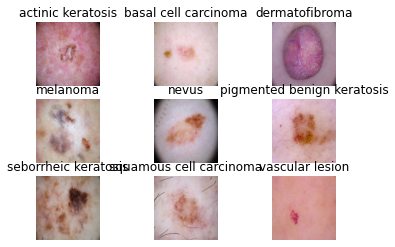

In [9]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
for i in range(len(class_names)):
    filtered_ds = train_ds.filter(lambda x, l: tf.math.equal(l[0], i))
    for image, label in filtered_ds.take(1):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(image[0].numpy().astype('uint8'))
        plt.title(class_names[label.numpy()[0]])
        plt.axis('off')

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
### Your code goes here

num_class = 9
model = tf.keras.Sequential([
    layers.Rescaling(scale = 1./255, input_shape = (180,180,3)),
    layers.Conv2D(16,3,padding='same',activation= 'relu'),
    layers.MaxPooling2D(pool_size = 2, strides = 2),    
    layers.Conv2D(32,3,padding='same',activation= 'relu'),
    layers.MaxPooling2D(pool_size = 2, strides = 2),
    layers.Conv2D(64,3,padding='same',activation= 'relu'),
    layers.MaxPooling2D(pool_size = 2, strides = 2),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(num_class)
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [12]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

In [13]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

### Train the model

In [14]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 29s 423ms/step - loss: 1.8602 - accuracy: 0.3170 - val_loss: 1.6278 - val_accuracy: 0.4228
Epoch 2/20
56/56 [==============================] - 22s 386ms/step - loss: 1.5871 - accuracy: 0.4475 - val_loss: 1.5110 - val_accuracy: 0.4430
Epoch 3/20
56/56 [==============================] - 22s 395ms/step - loss: 1.4467 - accuracy: 0.5000 - val_loss: 1.5441 - val_accuracy: 0.4452
Epoch 4/20
56/56 [==============================] - 22s 388ms/step - loss: 1.3695 - accuracy: 0.5212 - val_loss: 1.3750 - val_accuracy: 0.5056
Epoch 5/20
56/56 [==============================] - 22s 385ms/step - loss: 1.2527 - accuracy: 0.5608 - val_loss: 1.4142 - val_accuracy: 0.5145
Epoch 6/20
56/56 [==============================] - 22s 387ms/step - loss: 1.2118 - accuracy: 0.5753 - val_loss: 1.3689 - val_accuracy: 0.5347
Epoch 7/20
56/56 [==============================] - 22s 396ms/step - loss: 1.0949 - accuracy: 0.6183 - val_loss: 1.4335 - val_accuracy: 0.5257

### Visualizing training results

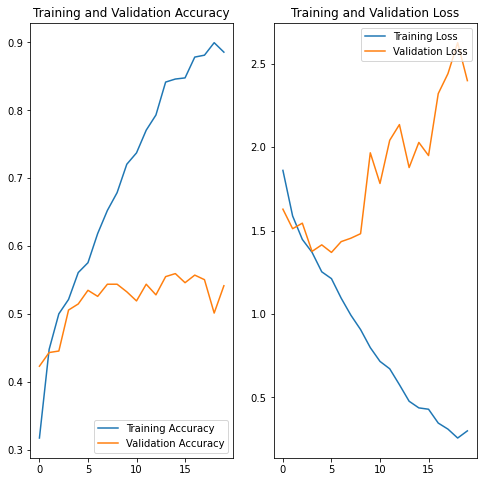

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

* The training accuracy is very high while the validation accuracy is around 50%, which is not desirable. 

* The loss on training set decreases after each epoch but in case of validation set it climbs back again after the 5th epoch.  


The model memorized the data instead of generalizing

In [16]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here

with tf.device('/cpu:0'):
    data_augmentation = tf.keras.Sequential([
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
    ])

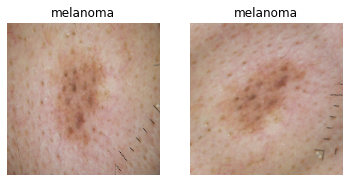

In [17]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

for image, label in train_ds.take(1):
        ax = plt.subplot(1, 2, 1)
        plt.imshow(image[0].numpy().astype('uint8'))
        plt.title(class_names[label.numpy()[0]])
        plt.axis('off')
        
        augmented = data_augmentation(image)
        ax = plt.subplot(1, 2, 2)
        plt.imshow(augmented[0].numpy().astype('uint8'))
        plt.title(class_names[label.numpy()[0]])
        plt.axis('off')

### Todo:
### Create the model, compile and train the model


In [18]:
## You can use Dropout layer if there is an evidence of overfitting in your findings


num_classes = 9
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.1),
  layers.Dense(num_classes)
])


### Compiling the model

In [19]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

### Training the model

In [20]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 27s 462ms/step - loss: 1.9624 - accuracy: 0.2757 - val_loss: 1.6793 - val_accuracy: 0.4072
Epoch 2/20
56/56 [==============================] - 24s 438ms/step - loss: 1.6444 - accuracy: 0.4135 - val_loss: 1.7123 - val_accuracy: 0.3557
Epoch 3/20
56/56 [==============================] - 24s 428ms/step - loss: 1.6221 - accuracy: 0.4208 - val_loss: 1.5813 - val_accuracy: 0.4497
Epoch 4/20
56/56 [==============================] - 25s 438ms/step - loss: 1.5512 - accuracy: 0.4587 - val_loss: 1.4398 - val_accuracy: 0.4989
Epoch 5/20
56/56 [==============================] - 25s 450ms/step - loss: 1.4479 - accuracy: 0.4978 - val_loss: 1.5090 - val_accuracy: 0.4743
Epoch 6/20
56/56 [==============================] - 25s 451ms/step - loss: 1.4275 - accuracy: 0.5095 - val_loss: 1.3885 - val_accuracy: 0.5280
Epoch 7/20
56/56 [==============================] - 25s 442ms/step - loss: 1.4114 - accuracy: 0.5045 - val_loss: 1.3782 - val_accuracy: 0.5481

### Visualizing the results

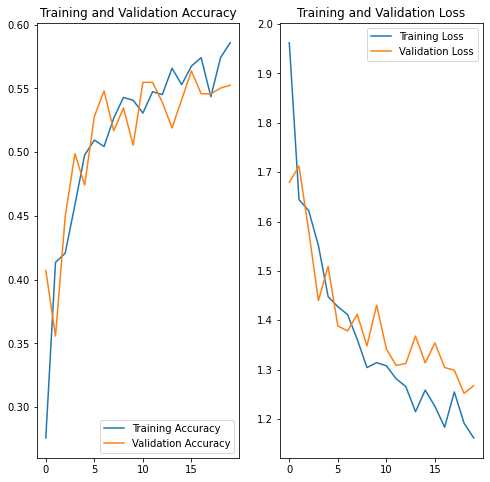

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

* The application of data augmentation and dropout layer drastically reduced the overfitting
* Results obtained from training and validation indicate that now the model is generalizing.
* Overall accuracy is not much great because training and validation accuracy have significant difference. 

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<BarContainer object of 9 artists>

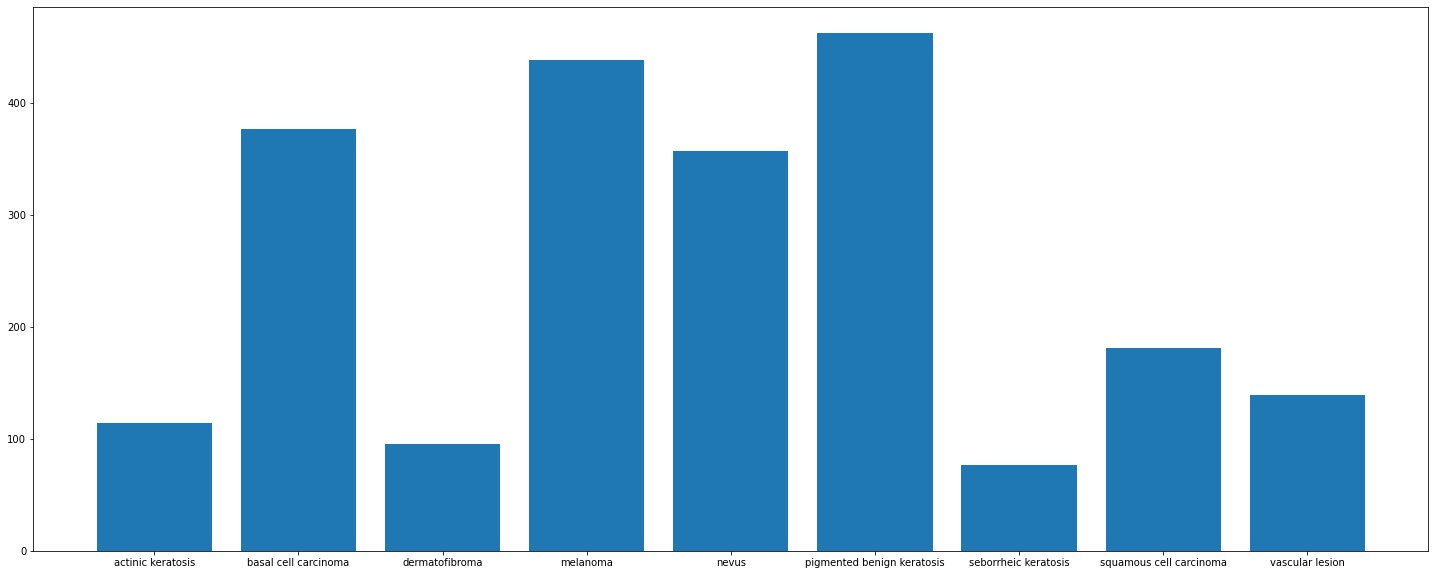

In [22]:
## Your code goes here.
class_count=[]
for i in class_names:
    class_count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,class_count)

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
* seborrheic keratosis
#### - Which classes dominate the data in terms proportionate number of samples?
* pigmented benign
* melanoma
* basal cell carcinoma 
* nevus

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [23]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [24]:
path_to_training_dataset='Files/Train/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x21075138E50>:   0%|         | 0/500 [00:00<?, ? Samples/s]

Initialised with 114 image(s) found.
Output directory set to Files/Train/actinic keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x2107536C8E0>: 100%|█| 500/500 [00:03<00:
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x210750FB310>:   2%| | 8/500 [00:00<00:58

Initialised with 376 image(s) found.
Output directory set to Files/Train/basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2107677BAF0>: 100%|█| 500/500 [00:03<00:00, 140.60 Samples
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x21076775BB0>:   2%| | 12/500 [00:00<01:0

Initialised with 95 image(s) found.
Output directory set to Files/Train/dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x210752D7B80>: 100%|█| 500/500 [00:03<00:00, 157.93 Samples
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x21076775F70>:   0%| | 0/500 [00:00<?, ?

Initialised with 438 image(s) found.
Output directory set to Files/Train/melanoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x21075300490>: 100%|█| 500/500 [00:13<00
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x210752D9C40>:   0%| | 1/500 [00:00<00:59,  8.33 Samples/s]

Initialised with 357 image(s) found.
Output directory set to Files/Train/nevus\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2107534AD00>: 100%|█| 500/500 [00:11<00:00, 43.02 Samples/
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x21075301250>:   4%| | 19/500 [00:00<00:0

Initialised with 462 image(s) found.
Output directory set to Files/Train/pigmented benign keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x21076769940>: 100%|█| 500/500 [00:02<00:
Executing Pipeline:   0%|                                                                | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to Files/Train/seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x210750A8190>: 100%|█| 500/500 [00:06<00:00, 77.54 Samples
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2107511A040>:   5%| | 23/500 [00:00<00:06, 69.81 Samples/s

Initialised with 181 image(s) found.
Output directory set to Files/Train/squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x21074D215E0>: 100%|█| 500/500 [00:02<00:00, 186.05 Samples
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x21074F734C0>:   4%| | 18/500 [00:00<00:0

Initialised with 139 image(s) found.
Output directory set to Files/Train/vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2107485F340>: 100%|█| 500/500 [00:02<00:00, 177.21 Samples


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [25]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [26]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['Files\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_2108782a-7e53-4362-b0b2-3173bac6ad4c.jpg',
 'Files\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_235646a4-299c-48aa-8f28-ba8ae8cc629d.jpg',
 'Files\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_32bbf702-7925-4e43-8c6c-3819c3f4a03c.jpg',
 'Files\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_37bc341c-fa5a-428e-9b9b-918b88f299e6.jpg',
 'Files\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_e9ed4ea2-3bcf-48a3-aa96-eda0304378ea.jpg',
 'Files\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_f3c97df8-4fc9-4022-bc69-7e75fb44bfba.jpg',
 'Files\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_f8baa476-d211-4280-ad13-5dc74ccd792d.jpg',
 'Files\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_070

In [27]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [28]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [29]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
#new_df = original_df.append(df2)

In [30]:
df2['Label'].value_counts()

dermatofibroma                500
seborrheic keratosis          500
pigmented benign keratosis    500
actinic keratosis             500
squamous cell carcinoma       500
basal cell carcinoma          500
melanoma                      500
vascular lesion               500
nevus                         500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [31]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [33]:
data_dir_train="Files/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [34]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [35]:
## your code goes here
num_classes = 9
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.1),
  layers.Dense(num_classes)
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [36]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [37]:
epochs = 50
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 [==============================] - 84s 484ms/step - loss: 2.1783 - accuracy: 0.1764 - val_loss: 1.9193 - val_accuracy: 0.2866
Epoch 2/50
169/169 [==============================] - 79s 466ms/step - loss: 1.7673 - accuracy: 0.3342 - val_loss: 1.5819 - val_accuracy: 0.4024
Epoch 3/50
169/169 [==============================] - 79s 464ms/step - loss: 1.5387 - accuracy: 0.4054 - val_loss: 1.4310 - val_accuracy: 0.4514
Epoch 4/50
169/169 [==============================] - 80s 474ms/step - loss: 1.4570 - accuracy: 0.4364 - val_loss: 1.4349 - val_accuracy: 0.4744
Epoch 5/50
169/169 [==============================] - 87s 511ms/step - loss: 1.3884 - accuracy: 0.4646 - val_loss: 1.4780 - val_accuracy: 0.4491
Epoch 6/50
169/169 [==============================] - 86s 507ms/step - loss: 1.3629 - accuracy: 0.4690 - val_loss: 1.3179 - val_accuracy: 0.5011
Epoch 7/50
169/169 [==============================] - 80s 473ms/step - loss: 1.2980 - accuracy: 0.5056 - val_loss: 1.2701 - val_ac

#### **Todo:**  Visualize the model results

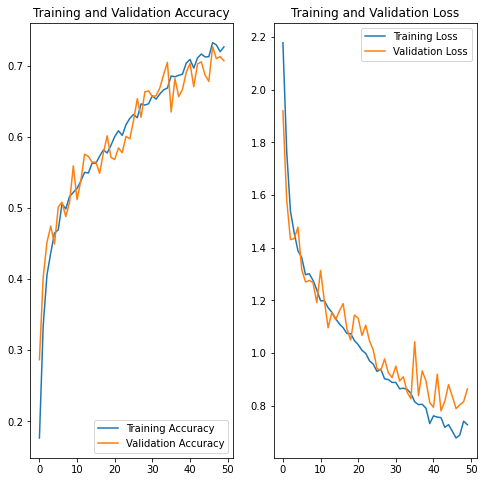

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

* Rebalancing of class using Augmentor has helped us to get rid of the overfitting. 
* The performance of the model is similar on both training and validation data.
* Both training and validation accuracy have been increased.
* We can further drop-out layer to increase the accuracy and minimize the chance of overfitting.

### Adding one more conv-pooling-dropout "layer" 

In [39]:
num_classes = 9
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.1),
  layers.Dense(num_classes)
])

In [40]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [41]:
epochs = 50
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 [==============================] - 88s 514ms/step - loss: 2.0393 - accuracy: 0.1968 - val_loss: 1.7646 - val_accuracy: 0.3541
Epoch 2/50
169/169 [==============================] - 85s 503ms/step - loss: 1.6356 - accuracy: 0.3644 - val_loss: 1.4947 - val_accuracy: 0.4328
Epoch 3/50
169/169 [==============================] - 85s 503ms/step - loss: 1.5114 - accuracy: 0.4075 - val_loss: 1.4179 - val_accuracy: 0.4677
Epoch 4/50
169/169 [==============================] - 86s 505ms/step - loss: 1.4380 - accuracy: 0.4334 - val_loss: 1.3853 - val_accuracy: 0.4484
Epoch 5/50
169/169 [==============================] - 85s 501ms/step - loss: 1.4108 - accuracy: 0.4514 - val_loss: 1.3246 - val_accuracy: 0.4796
Epoch 6/50
169/169 [==============================] - 85s 501ms/step - loss: 1.3781 - accuracy: 0.4588 - val_loss: 1.3614 - val_accuracy: 0.4759
Epoch 7/50
169/169 [==============================] - 85s 503ms/step - loss: 1.3378 - accuracy: 0.4707 - val_loss: 1.2847 - val_ac

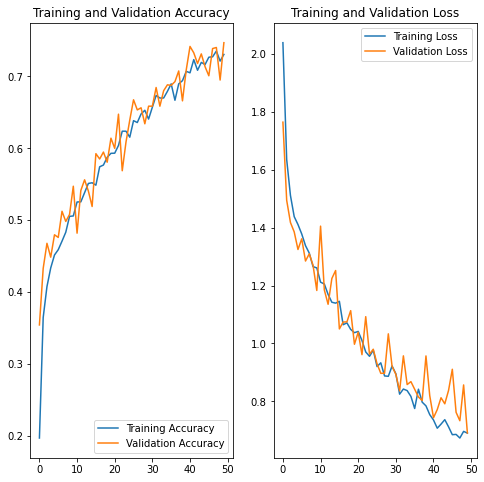

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()